<a href="https://colab.research.google.com/github/aslesani/pgmpy_fork/blob/master/src/default_test/imdb_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
'''Trains an LSTM model on the IMDB sentiment classification task.
The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.
# Notes
- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.
- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM, SimpleRNN
from keras.datasets import imdb

Using TensorFlow backend.


In [0]:
import matplotlib.pyplot as plt

def plot_train_val_graph(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)
  print('epochs:' , epochs)
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()


In [0]:
def get_max_len_of_sequences(list_of_sequences):
  lengths = [len(list_of_sequences[i]) for i in range(len(list_of_sequences))]
  return max(lengths) , min(lengths) , lengths

In [0]:
def get_set_of_sensor_events(list_of_sequences):
 
  set_of_sensor_events = set()
  
  for i in range(len(list_of_sequences)):
      set_of_sensor_events = set_of_sensor_events.union(set(list_of_sequences[i]))
  
  return set_of_sensor_events, len(set_of_sensor_events)
  

In [0]:
def read_data_from_CSV_file(dest_file , data_type ,  has_header = False , return_as_pandas_data_frame = False , remove_date_and_time = False , return_header_separately = False , convert_int_columns_to_int = False):
    '''
    this function is a replacement for read_data_from_PCA_output_file and read_data_from_PCA_digitized_file
    with more capabalities.
    
    Parameters:
    ==========
    dest_file: 
    data_type: type of data that should be read  
    has_header = if the file has header, it is set to True. The header is the first line that starts whit '#' character 
    return_as_pandas_data_frame = if True, the return_value is pandas Dataframe, else numpy ndaaray
    
    convert_int_columns_to_int: if the user want to keep date and time columns, then she should 
                                specify data_type as object and then set convert_int_columns_to_int to True
    
    Returns:
    ========
    return_value: type of it is pandas Dataframe or numpy ndaaray
    
    '''
    header = ""
    with open(dest_file,'r') as dest_f:
        data_iter = csv.reader(dest_f, 
                               delimiter = ',')#quotechar = '"')
    
        if has_header:
            header = next(data_iter)
            header[0] = header[0].split('# ')[1] # remove # from first element
        
        
        data = [data for data in data_iter]
    
    if remove_date_and_time:
        data = np.delete(np.delete(data, -1, 1), -1 , 1)

    return_value= np.asarray(data, dtype = data_type)
    
    if convert_int_columns_to_int:
        rows , cols_to_convert = np.shape(return_value)
        
        if remove_date_and_time == False:
            cols_to_convert -=2
        
        for r in range(rows):
            for c in range(cols_to_convert):
                return_value[r,c] = int(return_value[r,c])
        
    
    if return_as_pandas_data_frame:
        return_value = pd.DataFrame(return_value , columns = header)
        
    if return_header_separately:
        return header , return_value
    
    else:   
        return return_value



In [18]:
!git clone https://github.com/aslesani/pgmpy_fork.git


Cloning into 'pgmpy_fork'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (202/202), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 971 (delta 97), reused 146 (delta 63), pack-reused 769
Receiving objects: 100% (971/971), 562.13 KiB | 8.92 MiB/s, done.
Resolving deltas: 100% (527/527), done.


In [17]:
ls

sample_data/


In [19]:
!git clone https://github.com/aslesani/created_dataset.git

Cloning into 'created_dataset'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 90 (delta 75), reused 90 (delta 75), pack-reused 0
Unpacking objects: 100% (90/90), done.


In [0]:
!rm -r pgmpy_fork  

In [20]:
cd pgmpy_fork/src/default_test

/content/pgmpy_fork/src/default_test


In [24]:
cd ..

/content


In [0]:
ls

In [0]:
def convert_binary_classes_to_zero_and_one(data):
  
  values = sorted(list(set(data)))
  for i in range(len(data)):
    data[i] = values.index(data[i])

    
  return data

In [67]:
def test_convert_binary_classes_to_zero_and_one():
  data = [2,1,1,1,2]
  data = convert_binary_classes_to_zero_and_one(data)
  print(data)

[1, 0, 0, 0, 1]


In [0]:
from keras import backend as K

def mcor(y_true, y_pred):
    #matthews_correlation
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
 
 
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
 
 
    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)
 
 
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
 
 
    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
 
 
    return numerator / (denominator + K.epsilon())


def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [94]:
!pip install tabulate 

In [97]:
from tabulate import tabulate
print(tabulate([['Alice1111111111111111111111111111111111', 24], ['Bob', 19]], headers=['algorithm', 'acc']))


algorithm                                  acc
---------------------------------------  -----
Alice1111111111111111111111111111111111     24
Bob                                         19


In [0]:
def imdb_lstm_data_preparation(max_features = 20000, maxlen = 80):
  #max_features = 20000#number_of_events
  # cut texts after this number of words (among top max_features most common words)
  #maxlen = 10#max_seq_len

  print('Loading data...')
  (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
  print(len(x_train), 'train sequences')
  print(len(x_test), 'test sequences')

  #print('before apply pad_sequence, x_train[0]:' , x_train[0])

  print('Pad sequences (samples x time)')
  x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
  x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
  print('x_train shape:', x_train.shape)
  print('x_test shape:', x_test.shape)
  
  return x_train, x_test, y_train, y_test, max_features, maxlen

In [0]:
from read_write import read_sequence_of_bags_CSV_file_with_activity, read_sequence_based_CSV_file_with_activity, read_data_from_CSV_file
from keras.preprocessing.text import Tokenizer

def my_data_preparation(address_to_read):
  
  list_of_data , list_of_persons , _ = read_sequence_based_CSV_file_with_activity(file_address = address_to_read, has_header = True , separate_data_based_on_persons = False, separate_words= False)
  #sensor_events , number_of_events = get_set_of_sensor_events(sequences)
  
  list_of_persons = convert_binary_classes_to_zero_and_one(list_of_persons)
  
  tokenizer = Tokenizer(num_words = 122, filters='!"#$%&()*+,-./:;<=>?@[\]^`{|}~')
  #list_of_data = [r'salam man', r"'M38_off' , 'M38_on'"]
  tokenizer.fit_on_texts(list_of_data)
  sequences = tokenizer.texts_to_sequences(list_of_data)
  
  max_features = 121#number_of_events
  # cut texts after this number of words (among top max_features most common words)
  maxlen = 10#80#max_seq_len

  #print('before apply pad_sequence, x_train[0]:' , x_train[0])

  #80% of data for train and 20% for test
  train_numbers = int(0.8 * len(sequences))
  x_train, y_train = sequences[0: train_numbers] , list_of_persons[0:train_numbers]
  x_test, y_test = sequences[train_numbers+1:] , list_of_persons[train_numbers+1:]

  print('Pad sequences (samples x time)')
  x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
  x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
  print('x_train shape:', x_train.shape)
  print('x_test shape:', x_test.shape)

  return x_train, x_test, y_train, y_test, max_features, maxlen

In [0]:
#! cd pgmpy_fork/src/default_test
#!ls


In [0]:
#!git clone https://github.com/pgmpy/pgmpy 
cd ..
#!ls
#!cd pgmpy/
#pip install -r requirements.txt
#!python setup.py install

In [0]:
mydata = read_data_from_CSV_file(dest_file = address_to_save , data_type = int ,  has_header = False , return_as_pandas_data_frame = False , remove_date_and_time = True , return_header_separately = False , convert_int_columns_to_int = True)
    

In [0]:
max_seq_len, min_seq_len , lens = get_max_len_of_sequences(sequences)
print(max_seq_len, min_seq_len)

2216 1


In [86]:
address_to_read= r"created_dataset/Seq of sensor events_based on activities/based_on_activities.csv"

#x_train, x_test, y_train, y_test, max_features, maxlen = imdb_lstm_data_preparation(maxlen=10)
#my_x_train, my_x_test, my_y_train, my_y_test, my_max_features, my_maxlen = my_data_preparation(address_to_read)
x_train, x_test, y_train, y_test, max_features, maxlen = my_data_preparation(address_to_read)#imdb_lstm_data_preparation(maxlen=10)


Pad sequences (samples x time)
x_train shape: (2572, 10)
x_test shape: (643, 10)


In [70]:
print(set(y_train))

{0, 1}


In [0]:
x_train = x_train[0:2500]
y_train = y_train[0:2500]
x_test = x_test[2501:3200]
y_test = y_test[2501:3200]



In [0]:
y_train = y_train.tolist()
y_test = y_test.tolist()

In [64]:
print((y_train[0:10]))
print((my_x_train[0:10]))


[1, 0, 0, 1, 0, 0, 1, 0, 1, 0]
[[42 46 43 41 42 46 43 41 31 46]
 [ 9 29 13  9 57 61 13 58 30 62]
 [16 15 16 15 15 16 15 16 15 16]
 [ 2  2  1  2  1  2  1  2  1  2]
 [10  7 11  8  7  8  7  8  7  8]
 [30 61 13 62 66  1 33 65  2 34]
 [ 3 19  4  3  4  3 15 24 16  4]
 [ 2  2  1  2  1  2  2  1  2  1]
 [ 7  8 10  7  8 11  7  8  7  8]
 [61 13 62 58  7 66 65  8  7 62]]


In [0]:
def create_model_and_apply_on_data(x_train, y_train,x_test, y_test, max_features,embedding_vector_dim = 64, batch_size = 32, epochs = 5, 
                                   loss = 'binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'], plot_train_val_graph = False):
  
  #batch_size = 32

  print('Build model...')
  model = Sequential()
  model.add(Embedding(max_features+1, embedding_vector_dim))
  model.add(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
  model.add(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
  model.add(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.2))
  model.add(Dense(1, activation='sigmoid'))

  model.summary()

  # try using different optimizers and different optimizer configs
  model.compile(loss= loss,
                optimizer=optimizer,
                metrics= metrics)#, mcor,recall, f1])

  print('Train...')
  history = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_test, y_test))
  score, acc = model.evaluate(x_test, y_test,
                              batch_size=batch_size)
  print('Test score:', score)# i think score is loss value
  print('Test accuracy:', acc)
 
  if plot_train_val_graph:
      plot_train_val_graph(history)
      
  return score, acc, history

In [100]:
create_model_and_apply_on_data(x_train, y_train,x_test, y_test, max_features)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, None, 64)          7808      
_________________________________________________________________
simple_rnn_23 (SimpleRNN)    (None, None, 64)          8256      
_________________________________________________________________
simple_rnn_24 (SimpleRNN)    (None, None, 64)          8256      
_________________________________________________________________
simple_rnn_25 (SimpleRNN)    (None, 64)                8256      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 65        
Total params: 32,641
Trainable params: 32,641
Non-trainable params: 0
_________________________________________________________________
Train...
Train on 2572 samples, validate on 643 samples
Epoch 1/5
2572/2572 [==============================] - 5s 2ms/step 

In [0]:
embeddings = model.layers[0].get_weights()[0]
print(embeddings)

In [0]:
model.layers[1].

In [0]:
# `word_to_index` is a mapping (i.e. dict) from words to their index, e.g. `love`: 69
words_embeddings = {w:embeddings[idx] for w, idx in word_to_index.items()}

# now you can use it like this for example
print(words_embeddings['love'])  # possible output: [0.21, 0.56, ..., 0.65, 0.10]


In [0]:
print(type(score) , type(acc))

epochs: range(1, 11)


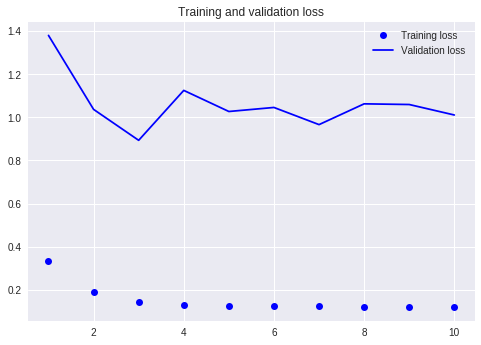